In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
import line_profiler as lp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU


c:\Users\matti\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on CPU
Running on CPU


## Dataset Testing

In [2]:
# lp profile of smooth_wandering_2D_complex_bound
# %load_ext line_profiler
# %lprun -f smooth_wandering_2D_complex_bound smooth_wandering_2D_complex_bound(64,200,bound=0.5,v_sigma=0.02,d_sigma=0.1)

345


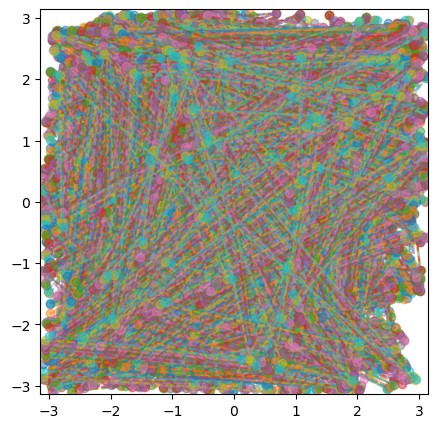

In [6]:
data,labels = smooth_wandering_2D_squarefix(200,200,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
# data,labels = rat_box(64,200,speed_mean=2,speed_std=1,box_size=1)

# Plot positions from labels
plt.figure(figsize=(5,5))
n = 51
plt.plot(labels[:n,:,0],labels[:n,:,1],"--o",alpha=0.5)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.show()

In [29]:
# data,labels = rat_box(64,200)

# # # data, labels = smooth_wandering_2D_bing(n_data=100,t_steps=20,bound=0.5)
# # x,y,vx,vy = random_walk(40)

# # # Plot 2D wandering
# plt.figure(figsize=(5,5))
# plt.plot(labels[:n,:,0],labels[:n,:,1],"--o",alpha=0.5)
# plt.show()

## Model

In [7]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)
# model1 = torch.compile(model1)

train = False

if train:
    _ = model1.train_gradual(epochs=10000)
    # model1.base_training_tsteps = 40
    # _ = model1.train(epochs=10000)
    model1.plot_losses(average=30)
else:
    # model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual+2000base.pt"))
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual.pt",map_location=torch.device('cpu')))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

In [6]:
# model1.base_training_tsteps = 200
# _ = model1.train(epochs=1)
# model1.plot_losses(average=30)

In [7]:
# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_10000gradual+2000base.pt")

## Analysis

### Norm of activity per timestep

In [8]:
# htss = model1.hts.norm(dim=2)
# htss = htss.cpu().detach().numpy()
# plot_norm(htss,avg_only=False)

### Tuning curves

#### 1D

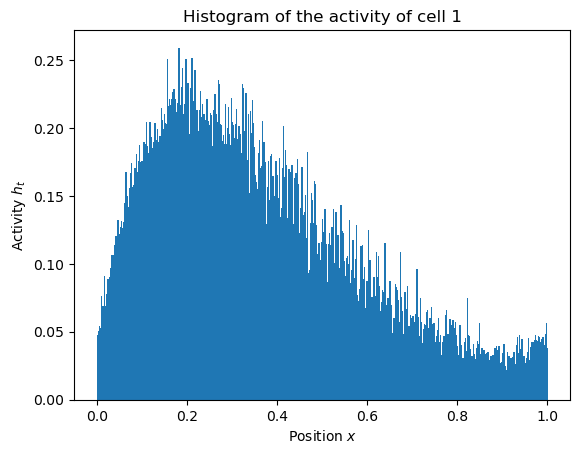

In [14]:
activity, bin_edges = tuning_curve(model1,bins=2000)
plot_tuning_curve(activity,bin_edges,1,spherical=False,linear=False,scale_to_one=True, plot_head_frac=1/10)

#### 2D

In [8]:
t_test = 40
test_batch_size = 5000
activity, bin_edges_x, bin_edges_y = tuning_curve_2D(model1,t_test=t_test,test_batch_size=test_batch_size,bins=50, in_activity=(data, labels))

100%|██████████| 128/128 [00:00<00:00, 219.29it/s]


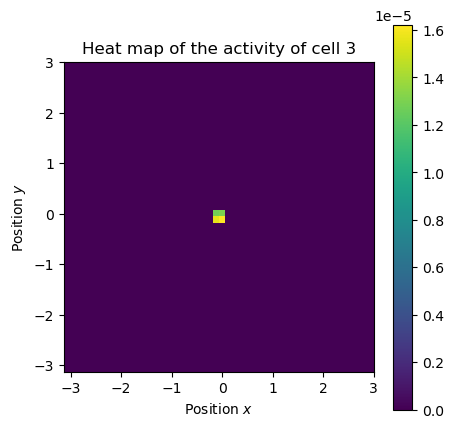

100%|██████████| 16/16 [00:00<00:00, 1999.97it/s]


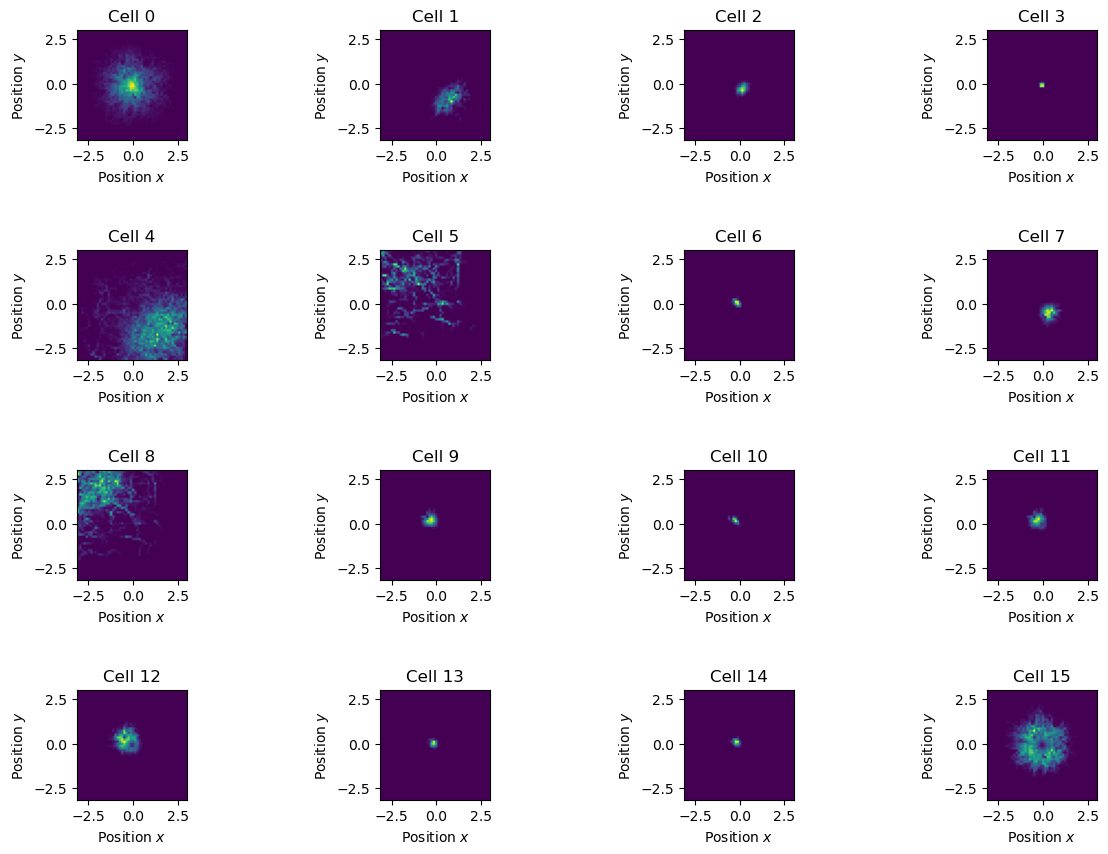

In [11]:
plot_2D_tuning_curve_2(activity,bin_edges_x, bin_edges_y,k_test=3,plot_head_frac=1/8,scale_to_one=False,more_plots=True)

### Low dimensional representations

#### 1D

Explained variance for PCA with 2 components: 92.188 %


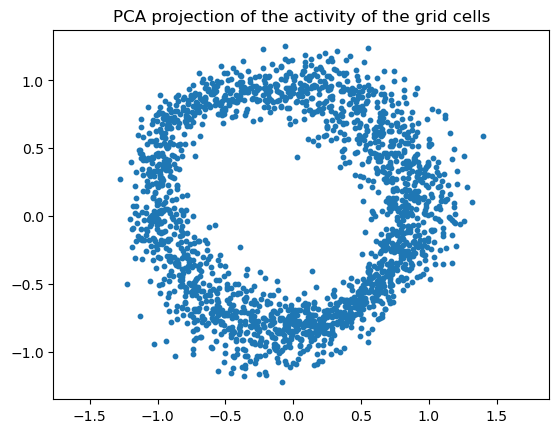

In [15]:
embedding, reducer = lowD_reduce(activity,if_pca=True,n_components=2,plot=True)

#### 2D

In [40]:
# xembedding, xreducer = lowD_reduce(xactivity,if_pca=True,n_components=2,plot=True)
# yembedding, yreducer = lowD_reduce(yactivity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

#### 1D

In [109]:
angs, dy, err, y_hat, y = test_angle_inference(model1,reducer)


Mean error:  0.10581753660929019


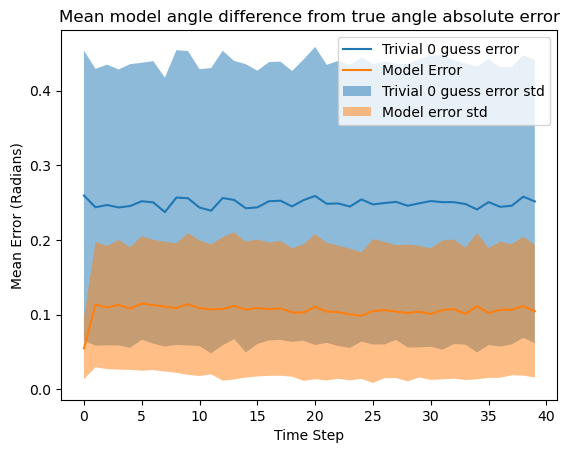

In [110]:
plot_accuracy(angs,dy,y_hat,y)

Mean error:  0.31318258251707565
Mean end error:  0.4360931054315451


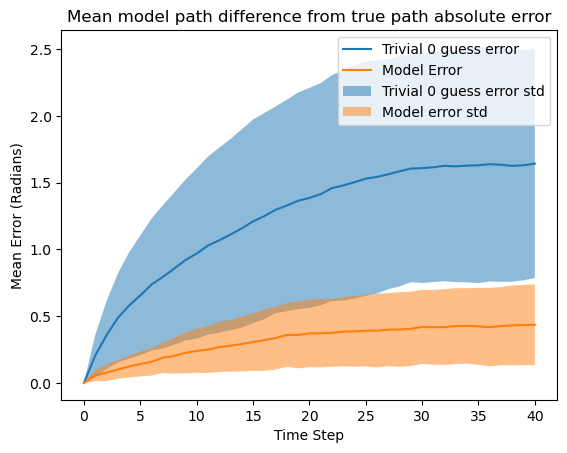

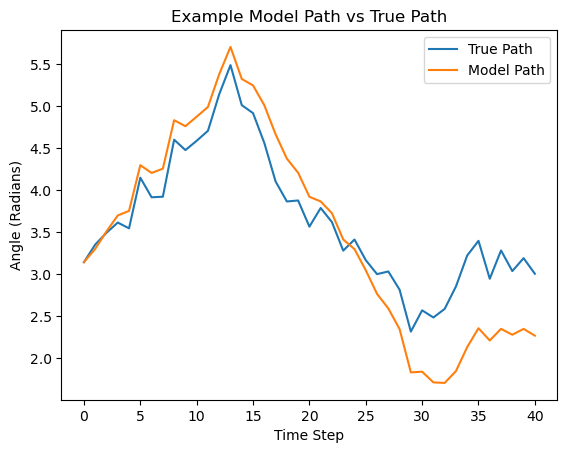

In [111]:
plot_path_accuracy(angs,y,example_path=1)

#### 2D

In [16]:
data,labels = smooth_wandering_2D_squarefix(200,200,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
# data,labels = smooth_wandering_2D_complex_bound(200,200,bound=0.5,v_sigma=0.01,d_sigma=0.1)

xdata = data[:,:,0]
ydata = data[:,:,1]
xlabels = labels[:,:,0]
ylabels = labels[:,:,1]

# call old y for theta (theoretical angles)
xangs, xdtheta, xerr, xhidden_state, xtheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(xdata,xlabels),start=0)
yangs, ydtheta, yerr, yhidden_state, ytheta = test_angle_inference(model1,reducer,t_test=200,in_activity=(ydata,ylabels),start=0)

160
Mean error:  0.03137954034465108
Mean error:  0.03146452856232695


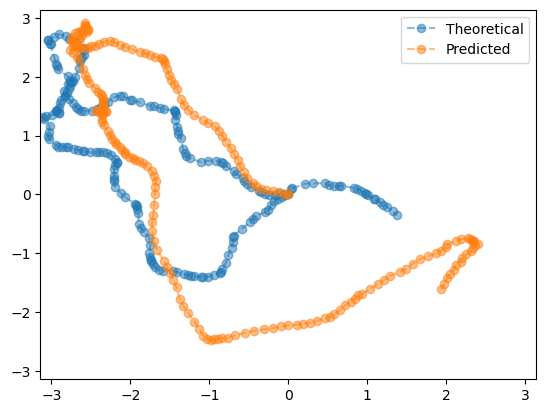

In [21]:

n = 13
plt.plot(xtheta[n,:],ytheta[n,:],'--o', alpha=0.5, label='Theoretical')

xpath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
ypath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
# xpath[:,0] = 0
# ypath[:,0] = 0
for i in range(1,xangs.shape[1]+1):
    xpath[:,i] = xpath[:,i-1] + xangs[:,i-1]
    ypath[:,i] = ypath[:,i-1] + yangs[:,i-1]

plt.plot(xpath[n,:],ypath[n,:],'--o', alpha=0.5, label='Predicted')
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
# plt.axis('equal')
plt.legend()
plt.show()

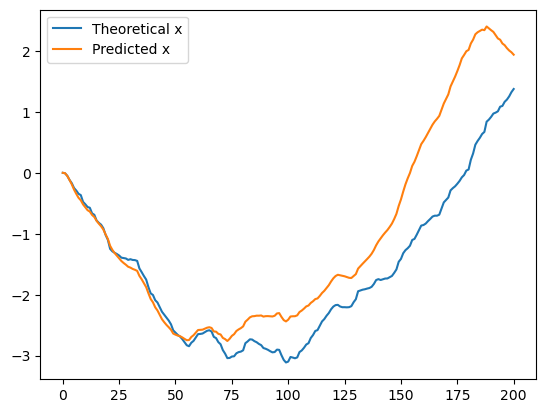

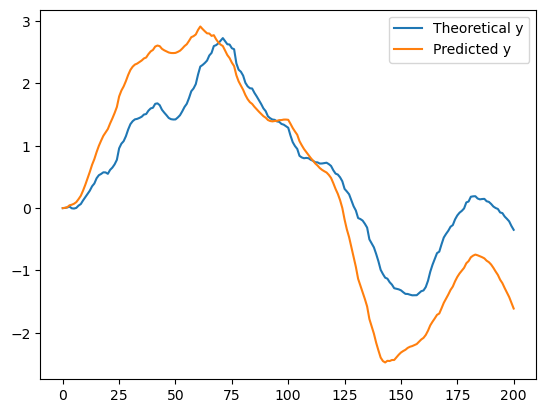

In [22]:
plt.plot(xtheta[n,:],label="Theoretical x")
plt.plot(xpath[n,:],label="Predicted x")
plt.legend()
plt.show()
plt.plot(ytheta[n,:],label="Theoretical y")
plt.plot(ypath[n,:],label="Predicted y")
plt.legend()
plt.show()